In [ ]:
! pip install transformers
# ! pip install tensorflow==2.13.0

from google.colab import drive
drive.mount('/content/drive/')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.5 MB/s eta 0:00:00
Mounted at /content/drive/


In [ ]:
! ls /content/drive/MyDrive/Bikram/


acc_figures_14_07.pdf		  latest_class_10000.csv
acc_figures.pdf			  latest_class.csv
acc_loss_figures_10000_14_07.pdf  model_100000_07_14.h5
acc_loss_figures_14_07.pdf	  model_10000_07_14.h5
data-gen-3.py			  model_10000_111.h5
dataset.csv			  new_test.csv
khanal_model.h5			  test_data.csv
latest_class_100000.csv


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, DistilBertForSequenceClassification, DistilBertTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import itertools
from tensorflow.nn import softmax
import re
from sklearn.preprocessing import LabelEncoder
import os
import pandas as pd
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import balanced_accuracy_score,classification_report,f1_score,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
np.random.seed(42)


# Dynamically allocate GPU memory
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Set the TF_GPU_ALLOCATOR environment variable
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'



In [ ]:
physical_devices,tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.12.0')

In [ ]:
# dataset_url = "../data_generator/initial_dataset_additonal_api_balanced_normal.csv"
# dataset_url = "dataset.csv"
# dataset_url = "/content/drive/MyDrive/Bikram/test_data.csv"
dataset_url_10000 = "/content/drive/MyDrive/Bikram/latest_class_10000.csv"
dataset_url_100000 = "/content/drive/MyDrive/Bikram/latest_class_100000.csv"
model_url = "/content/drive/MyDrive/Bikram/model_10000_07_14.h5"

In [ ]:
data = []
with open(dataset_url_10000, 'r') as csvfile:
    for line in csvfile:
        if len(line) > 5:
            a, b = line.split('",', 1)
            a, b = a[2:], b[2:-2]
            bs = re.findall(r"'(.*?)'", b, re.DOTALL)
            bs = ", ".join(bs)
            data.append([a,bs])
# data = data[:10000]
len(data)
# data = data[:100000]

10000

In [ ]:
# Separate code from actions
code = [item[0] for item in data]
actions = [item[1] for item in data]

In [ ]:
# Create a DataFrame from the deserialized data
df = pd.DataFrame(list(zip(code, actions)), columns=['code', 'actions'])
df.head(10)

,code,actions
0,"""for iodine in range(len(data0)):\n\tdata[iodi...",map()
1,"""for element in list0:\n\tresults.append(eleme...",map()
2,"""result = []\nfor num24 in numbers:\n\tresult....",map()
3,"""result = ''\nfor str in strings:\n\tresult +=...","map(), reduce()"
4,"""result = []\nfor num9 in numbers:\n\tif num9 ...","map(), filter()"
5,"""result = []\nfor num8 in numbers:\n\tif num8 ...","map(), filter()"
6,"""result = []\nfor product10 in products:\n\tif...",filter()
7,"""for element4 in array:\n\tif element4 % 3 == ...",filter()
8,"""medium = []\nfor score23 in scores:\n\tif sco...","filter(), reduce()"
9,"""result = 0\nfor item23 in items:\n\tresult = ...",reduce()


In [ ]:
unique,count = np.unique(df['actions'],return_counts = True)


In [ ]:
len(set(df['actions']))

111

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the code
input_ids = [tokenizer.encode(c, add_special_tokens=True) for c in df['code']]

# Pad sequences to ensure uniform length
code_padded = pad_sequences(input_ids, maxlen=256, dtype="long", value=0, truncating="post", padding="post")
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder to the actions
label_encoder.fit(df['actions'])

# Transform the actions to integers
actions_encoded = label_encoder.transform(df['actions'])
action_one_hot = to_categorical(actions_encoded, num_classes = len(set(df['actions'])))

In [ ]:
code_train, code_test, actions_train, actions_test = train_test_split(code_padded, action_one_hot, test_size=0.2, random_state=42,shuffle=True)
code_val, code_test, actions_val, actions_test = train_test_split(code_test, actions_test, test_size=0.5, random_state=42,shuffle=True)

In [ ]:
print(f"Training code size: {len(code_train)}")
print(f"Validation code size: {len(code_val)}")
print(f"Test code size: {len(actions_test)}")

Training code size: 8000
Validation code size: 1000
Test code size: 1000


In [ ]:
predicted_label = label_encoder.inverse_transform([actions_encoded[200]])
# Get the integer-encoded label from the one-hot encoded label
integer_encoded_label = np.argmax(action_one_hot[200])
# Decode the integer-encoded label to the original class label
predicted_label_onehot = label_encoder.inverse_transform([integer_encoded_label])

In [ ]:
# Checking if the encoding is right. Check for sample number 200
print(f"The original data sample 200 is: {data[200]}")
print(f"The data after splitting into code and sample is: {code[200],actions[200]}")
print(f"The code sample after decoding the tokenizer is {tokenizer.decode(code_padded[200])}")
print(f"The label after decoding the label encoding is: {predicted_label_onehot}")
print(f"The label after decoding the label one hot encoding is: {predicted_label_onehot}")


The original data sample 200 is: ['"result = 0\\nfor val23 in data:\\n\\tresult += val23 * 5', 'map(), reduce()']
The data after splitting into code and sample is: ('"result = 0\\nfor val23 in data:\\n\\tresult += val23 * 5', 'map(), reduce()')
The code sample after decoding the tokenizer is [CLS] " result = 0 \ nfor val23 in data : \ n \ tresult + = val23 * 5 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [ ]:
assert predicted_label_onehot == actions[200]

In [ ]:
print(f"The current unique class is: {len(set(df['actions']))}")
assert len(set(df['actions'])) == len(set(actions_encoded))

The current unique class is: 111


In [ ]:
# from keras.src.metrics.confusion_metrics import TruePositives
# Define the BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = len(set(df['actions'])))
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(mlb.classes_))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metric_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'Categorical_accuracy')
# metric_f1 = tf.keras.metrics.F1Score(name = 'f1_score')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric_accuracy])
# Train the model


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# import tensorflow as tf

class MetricsLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        # Initialize lists to store metrics
        self.train_loss = []
        self.train_accuracy = []
        self.train_f1 = []
        self.val_loss = []
        self.val_accuracy = []
        self.val_f1 = []

    def on_batch_end(self, batch, logs=None):
        # Append training metrics after each batch
        self.train_loss.append(logs['loss'])
        self.train_accuracy.append(logs['Categorical_accuracy'])
        # self.train_f1.append(logs['f1_score'])

    def on_epoch_end(self, epoch, logs=None):
        # Append validation metrics after each epoch
        self.val_loss.append(logs['val_loss'])
        self.val_accuracy.append(logs['val_Categorical_accuracy'])
        # self.val_f1.append(logs['val_f1_score'])


In [ ]:
# Train the model
# Instantiate the custom callback
metrics_logger = MetricsLogger()

# Train the model with the custom callback
model.fit(code_train, actions_train, epochs= 5, batch_size = 32, validation_data=(code_val, actions_val), callbacks=[metrics_logger])

# model.fit(code_train, actions_train, epochs=2, batch_size = 64, validation_data=(code_val, actions_val))


Epoch 1/5
250/250 [==============================] - 489s 2s/step - loss: 3.9564 - Categorical_accuracy: 0.1924 - val_loss: 2.6422 - val_Categorical_accuracy: 0.5420
Epoch 2/5
250/250 [==============================] - 445s 2s/step - loss: 1.7787 - Categorical_accuracy: 0.7372 - val_loss: 1.0669 - val_Categorical_accuracy: 0.8900
Epoch 3/5
250/250 [==============================] - 444s 2s/step - loss: 0.7319 - Categorical_accuracy: 0.9494 - val_loss: 0.4593 - val_Categorical_accuracy: 0.9650
Epoch 4/5
250/250 [==============================] - 445s 2s/step - loss: 0.3366 - Categorical_accuracy: 0.9872 - val_loss: 0.2350 - val_Categorical_accuracy: 0.9860
Epoch 5/5
250/250 [==============================] - 444s 2s/step - loss: 0.1834 - Categorical_accuracy: 0.9950 - val_loss: 0.1312 - val_Categorical_accuracy: 0.9950


In [ ]:
# Train the model
# Instantiate the custom callback
metrics_logger = MetricsLogger()

# Train the model with the custom callback
model.fit(code_train, actions_train, epochs= 5, batch_size = 32, validation_data=(code_val, actions_val), callbacks=[metrics_logger])

# model.fit(code_train, actions_train, epochs=2, batch_size = 64, validation_data=(code_val, actions_val))


Epoch 1/5
250/250 [==============================] - 486s 2s/step - loss: 4.0937 - Categorical_accuracy: 0.1334 - val_loss: 2.9738 - val_Categorical_accuracy: 0.4450
Epoch 2/5
250/250 [==============================] - 443s 2s/step - loss: 2.0816 - Categorical_accuracy: 0.6712 - val_loss: 1.3033 - val_Categorical_accuracy: 0.8430
Epoch 3/5
250/250 [==============================] - 443s 2s/step - loss: 0.9460 - Categorical_accuracy: 0.9036 - val_loss: 0.6277 - val_Categorical_accuracy: 0.9280
Epoch 4/5
250/250 [==============================] - 443s 2s/step - loss: 0.4550 - Categorical_accuracy: 0.9709 - val_loss: 0.3050 - val_Categorical_accuracy: 0.9790
Epoch 5/5
250/250 [==============================] - 443s 2s/step - loss: 0.2366 - Categorical_accuracy: 0.9936 - val_loss: 0.1633 - val_Categorical_accuracy: 0.9950


# Temp start

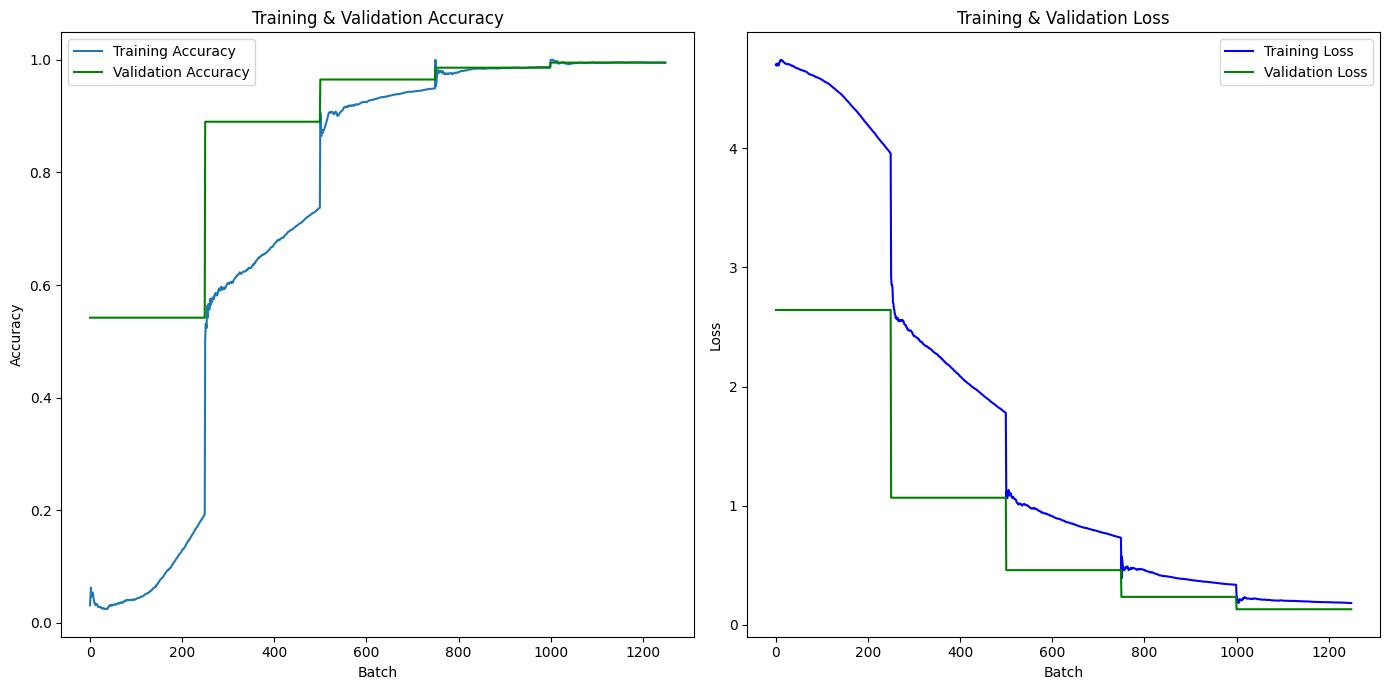

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the number of batches per epoch
batches_per_epoch = len(metrics_logger.train_loss) // len(metrics_logger.val_loss)

# Repeat the validation metrics for each batch within an epoch
val_accuracy_repeated = np.repeat(metrics_logger.val_accuracy, batches_per_epoch)
val_loss_repeated = np.repeat(metrics_logger.val_loss, batches_per_epoch)

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot Training & Validation Accuracy
axes[0].plot(metrics_logger.train_accuracy, '-', label="Training Accuracy")
axes[0].plot(val_accuracy_repeated, 'g-', label="Validation Accuracy")
axes[0].set_title("Training & Validation Accuracy")
axes[0].set_xlabel("Batch")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

# Plot Training & Validation Loss
axes[1].plot(metrics_logger.train_loss, 'b-', label="Training Loss")
axes[1].plot(val_loss_repeated, 'g-', label="Validation Loss")
axes[1].set_title("Training & Validation Loss")
axes[1].set_xlabel("Batch")
axes[1].set_ylabel("Loss")
axes[1].legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Bikram/acc_loss_figures_10000_15_07.png",dpi = 400)
plt.show()


In [ ]:
# Evaluate the model on the test set
model.evaluate(code_test, actions_test)

32/32 [==============================] - 19s 602ms/step - loss: 0.1430 - Categorical_accuracy: 0.9970


[0.14299844205379486, 0.996999979019165]

In [ ]:

# Let's assume that you have some test data in variables code_test and actions_test

# Number of samples to display
num_samples = 10

# Select a subset of the test data
code_samples = code_test[:num_samples]
actions_samples = actions_test[:num_samples]

# Make predictions using the model
logits = model.predict(code_samples)

# Extract the logits from the TFSequenceClassifierOutput object
logits_values = logits.logits

# Convert logits to probabilities
probs = softmax(logits_values)

# Find the class with the maximum probability
predicted_classes = np.argmax(probs, axis=1)

# Decode the predicted class indices back to labels
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Decode the real labels from integer to original

# Print the real and predicted labels
for i in range(num_samples):
    print(f"Sample {i+1}")
    integer_encoded_label = np.argmax(actions_samples[i])
    # Decode the integer-encoded label to the original class label
    real_labels = label_encoder.inverse_transform([integer_encoded_label])
    code_snap = code_samples[i]
    decode_code_snap = tokenizer.decode(code_snap)
    # replace ["SEP"], ["PAD"] and ["CLS"] tokens with empty string
    decode_code_snap = decode_code_snap.replace("[SEP]", "").replace("[PAD]", "").replace("[CLS]", "")
    decode_code_snap = decode_code_snap.replace("\ n", "\n\t")
    decode_code_snap = decode_code_snap.replace("\ t", "\t")
    print(f"Code: {decode_code_snap}")
    print(f"Real label: {real_labels}")
    print(f"Predicted label: {[predicted_labels[i]]}\n")
    print("--------------------------------------------------")
    # break

1/1 [==============================] - 6s 6s/step
Sample 1
Code:  " result = 0 
	for num313 in numbers : 
	 	result + = num313 * * 2                                                                                                                                                                                                                                   
Real label: ['map(), reduce()']
Predicted label: ['map(), reduce()']

--------------------------------------------------
Sample 2
Code:  " result = [ ] 
	for num321 in numbers : 
	 	result. append ( num321 * 5 ) 
	result. sort ( reverse = true )                                                                                                                                                                                                                     
Real label: ['map(), sortBy()']
Predicted label: ['map(), sortBy()']

--------------------------------------------------
Sample 3
Code:  " result = [ ] 
	for city36 in cities : 
	 	

In [ ]:
# Make predictions using the model
logits = model.predict(code_test)

# Extract the logits from the TFSequenceClassifierOutput object
logits_values = logits.logits
# Convert logits to probabilities
probs = softmax(logits_values)
predicted_classes = np.argmax(probs, axis=1)
y_test = [np.argmax(actions_test[i]) for i in range(len(actions_test))]

bal_acc=balanced_accuracy_score(y_test,predicted_classes)
f1score = f1_score(y_test,predicted_classes,average='macro')
# classification_report_ = classification_report(y_test,predicted_classes)
accuracy = accuracy_score(y_test,predicted_classes)
# bal_acc = balanced_accuracy_score(y_test,predicted_classes)
print(f"F1 Socre: {f1score}")
print(f"Balanced Accuracy: {bal_acc}")
print(f"Accuracy: {accuracy}")
# print(f"Classification Report: {classification_report}")

32/32 [==============================] - 16s 511ms/step
F1 Socre: 0.9978770370952935
Balanced Accuracy: 0.9977099095089749
Accuracy: 0.997


In [ ]:
import tensorflow as tf
tf.__version__



'2.12.0'

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-cbe1dab0-2da3-cb55-8c52-b7034c60b5d0)


In [ ]:
!lscpu |grep 'Model name'

Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz
